In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
#from hurstexponent.hurst_exponent import HurstEstimator

In [3]:
from liquidity.util.data_util import get_series_acf, get_nonlinear_acf
from liquidity.util.feature_util import add_returns
from powerlaw_function import Fit

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
ACF_RANGE = 1001

# Load data

In [5]:
tsla_df_mo = pd.read_csv('../../../../data/market_orders/TSLA-2016-R1.csv', header=0,index_col=0)
msft_df_mo = pd.read_csv('../../../../data/market_orders/MSFT-2016-R1.csv', header=0, index_col=0)
amzn_df_mo = pd.read_csv('../../../../data/market_orders/AMZN-2016-R1.csv', header=0, index_col=0)
nflx_df_mo = pd.read_csv('../../../../data/market_orders/NFLX-2016-R1.csv', header=0, index_col=0)
ebay_df_mo = pd.read_csv('../../../../data/market_orders/EBAY-2016-R1.csv', header=0, index_col=0)
appl_df_mo = pd.read_csv('../../../../data/market_orders/APPL-2016-R1.csv', header=0, index_col=0)

In [8]:
# Compute returns
tsla_returns = add_returns(tsla_df_mo, pct=False, remove_first=True)['returns']
msft_returns = add_returns(msft_df_mo, pct=False, remove_first=True)['returns']
amzn_returns = add_returns(amzn_df_mo, pct=False, remove_first=True)['returns']
nflx_returns = add_returns(nflx_df_mo, pct=False, remove_first=True)['returns']
ebay_returns = add_returns(ebay_df_mo, pct=False, remove_first=True)['returns']
appl_returns = add_returns(appl_df_mo, pct=False, remove_first=True)['returns']


{'TSLA': 1         0.000
 2        -0.095
 3        -0.010
 4        -0.090
 5        -0.005
           ...  
 757335   -0.005
 757336   -0.045
 757337    0.015
 757338   -0.005
 757339    0.035
 Name: returns, Length: 757339, dtype: float64}

In [7]:
# Construct linear ACF series
linear_return_acf_tsla = get_series_acf(tsla_returns, ACF_RANGE)[1:]
linear_return_acf_msft = get_series_acf(msft_returns, ACF_RANGE)[1:]
linear_return_acf_amzn = get_series_acf(amzn_returns, ACF_RANGE)[1:]
linear_return_acf_nflx = get_series_acf(nflx_returns, ACF_RANGE)[1:]
linear_return_acf_ebay = get_series_acf(ebay_returns, ACF_RANGE)[1:]
linear_return_acf_appl = get_series_acf(appl_returns, ACF_RANGE)[1:]

# Construct nonlinear ACF series
nonlinear_return_acf_tsla = get_nonlinear_acf(tsla_returns, ACF_RANGE, method='kendall')[1:]
nonlinear_return_acf_msft = get_nonlinear_acf(msft_returns, ACF_RANGE, method='kendall')[1:]
nonlinear_return_acf_amzn = get_nonlinear_acf(amzn_returns, ACF_RANGE, method='kendall')[1:]
nonlinear_return_acf_nflx = get_nonlinear_acf(nflx_returns, ACF_RANGE, method='kendall')[1:]
nonlinear_return_acf_ebay = get_nonlinear_acf(ebay_returns, ACF_RANGE, method='kendall')[1:]
nonlinear_return_acf_appl = get_nonlinear_acf(appl_returns, ACF_RANGE, method='kendall')[1:]


/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


KeyboardInterrupt: 

In [ ]:
# Linear ACF
linear_return_acf_tsla[:10]

In [ ]:
# Nonlinear ACF
nonlinear_return_acf_tsla[:10]

# 1. Linear vs nonlinear ACF

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn't contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results. However, the Kendall correlation would detect non-linear relationships if they exist, but if they don't, it would just mirror the results of the Pearson correlation in which case it's best to use Kendall in case a non-linear relation holds for some data in our sample.

In [ ]:
linear_acfs = {
  'TSLA': linear_return_acf_tsla,
  'MSFT': linear_return_acf_msft,
  'AMZN': linear_return_acf_amzn,
  'NFLX': linear_return_acf_nflx,
  'EBAY': linear_return_acf_ebay,
  'APPL': linear_return_acf_appl
}

nonlinear_acfs = {
  'TSLA': nonlinear_return_acf_tsla,
  'MSFT': nonlinear_return_acf_msft,
  'AMZN': nonlinear_return_acf_amzn,
  'NFLX': nonlinear_return_acf_nflx,
  'EBAY': nonlinear_return_acf_ebay,
  'APPL': nonlinear_return_acf_appl
}

In [ ]:
# Save data for lazy loading
# pickle.dump(linear_acfs, open("linear_acfs.pkl", "wb"))
# pickle.dump(nonlinear_acfs, open("nonlinear_acfs.pkl", "wb"))

In [6]:
linear_acfs = pickle.load(open("linear_acfs.pkl", "rb"))
nonlinear_acfs = pickle.load(open("nonlinear_acfs.pkl", "rb"))

In [7]:
def plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs):

    linear_acf = linear_acfs[stock_name]
    nonlinear_acf = nonlinear_acfs[stock_name]

    plt.figure(figsize=(14, 4))

    # Original scale
    plt.subplot(1, 3, 1)
    plt.plot(range(1, ACF_RANGE), linear_acf, label='Linear')
    plt.plot(range(1, ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')
    plt.grid(False)
    plt.legend(frameon=False)

    # log scale
    plt.subplot(1, 3, 2)
    plt.plot(range(1, ACF_RANGE), linear_acf, label='Linear')
    plt.plot(range(1, ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')
    plt.grid(False)
    plt.loglog()
    plt.legend(frameon=False)
    plt.suptitle(f'Linear vs nonlinear ACF across lags for {stock_name} MO Returns')

    # Difference
    plt.subplot(1, 3, 3)
    difference = [x1-x2 for x1, x2 in zip(linear_acf, nonlinear_acf)]
    plt.plot(range(1, ACF_RANGE), difference, label="Difference", color='red')
    plt.legend(frameon=False)
    plt.grid(False)
    plt.suptitle(f'Linear vs nonlinear ACF across lags for {stock_name} MO Returns')

    print(f'{stock_name} Max difference: {max(difference)}')

    plt.show()


TSLA Max difference: 0.001487226568044211


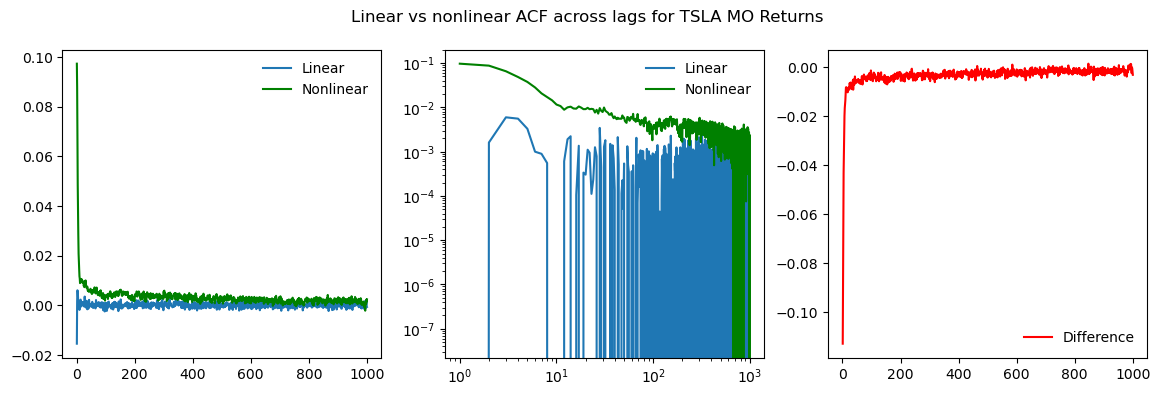

MSFT Max difference: 0.02102738236760209


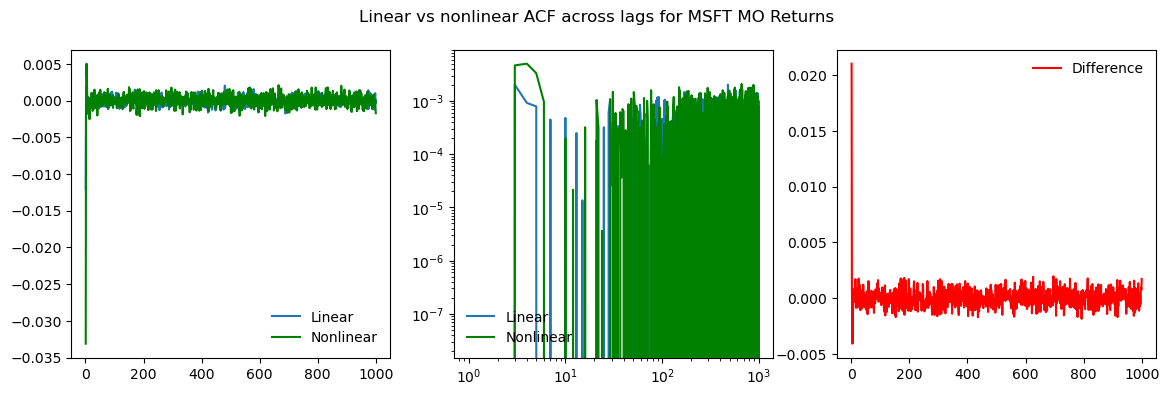

AMZN Max difference: -0.0005770916671605432


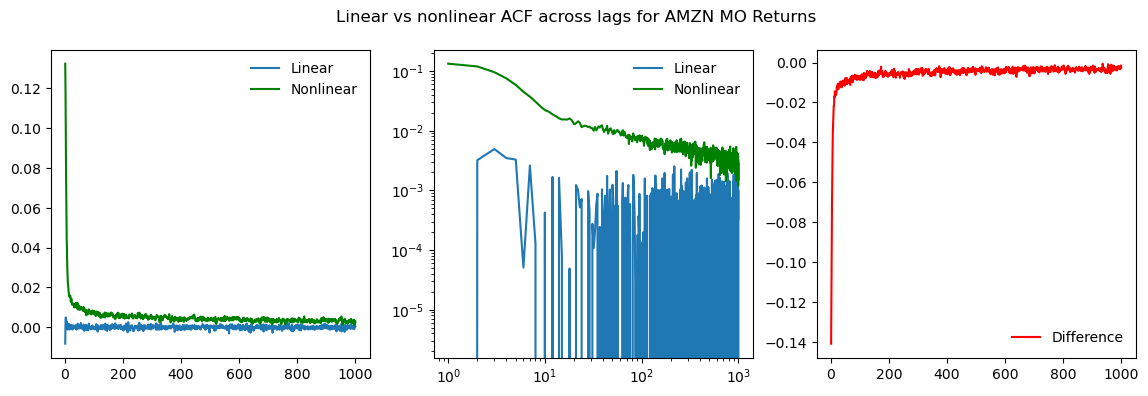

NFLX Max difference: 0.0016400986706111734


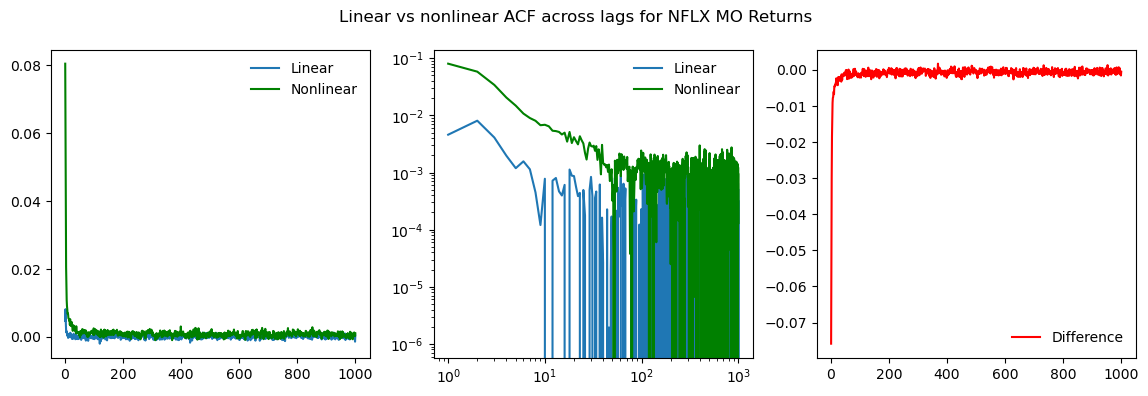

EBAY Max difference: 0.026295267053883825


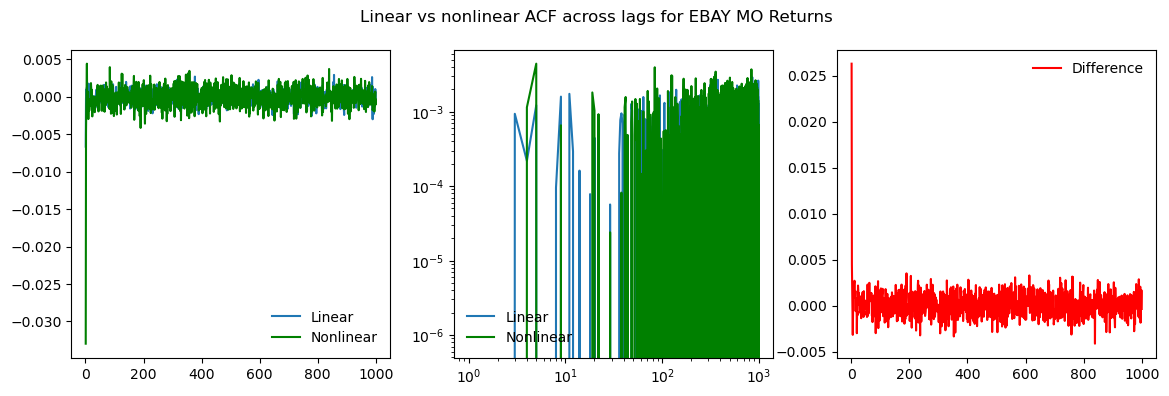

APPL Max difference: 0.0008223723498360359


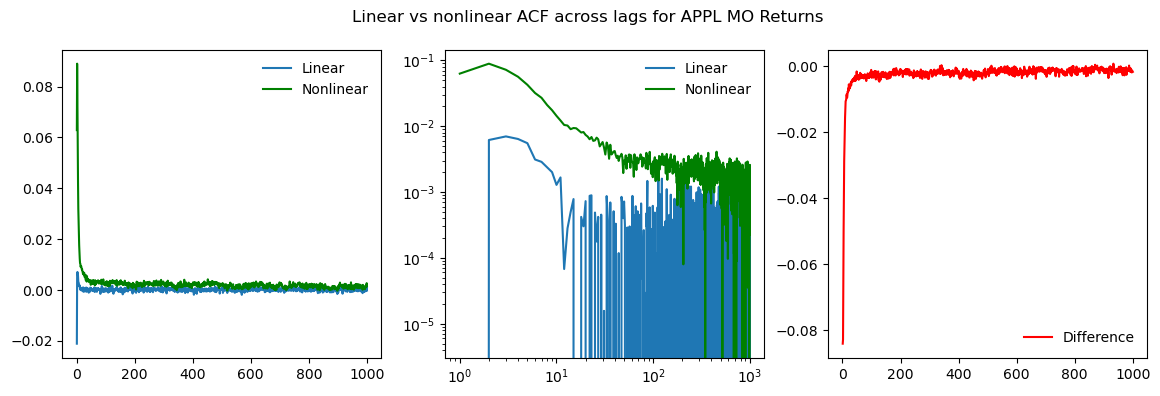

In [8]:
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

# 2. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time. (There is at least one unit root)

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [9]:
# ADF test
def print_ADF_test_results_for_series(sample, name: str, alpha=0.05):
    # Convert list to pandas Series if necessary
    if isinstance(sample, list):
        sample = pd.Series(sample)

    # Replace inf and -inf with nan
    sample.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop nan values
    sample.dropna(inplace=True)

    print(name)
    adf, p, usedlag, nobs, cvs, aic = adfuller(sample)
    adf_results_string = 'ADF: {:.2f}\np-value: {:.2f},\nN: {}, \ncritical values: {}'
    print(adf_results_string.format(adf, p, nobs, cvs))

    # Interpretation
    if p < alpha:
        print("We reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be stationary.")
    else:
        print("We cannot reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be non-stationary.")

    print('\n')

In [10]:
for stock, data in nonlinear_acfs.items():
    print_ADF_test_results_for_series(data, stock)

TSLA
ADF: -5.01
p-value: 0.00,
N: 987, 
critical values: {'1%': -3.4369927443074353, '5%': -2.864472756705845, '10%': -2.568331546097238}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -50.97
p-value: 0.00,
N: 999, 
critical values: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -4.70
p-value: 0.00,
N: 978, 
critical values: {'1%': -3.437054035425408, '5%': -2.8644997864059363, '10%': -2.5683459429326576}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -9.34
p-value: 0.00,
N: 991, 
critical values: {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
ADF: -14.34
p

# 3. Fitting power law functions

## 3.1. Data pre-processing

In [11]:
# Construct values for each dimension, x- and y-axis, of our function
def construct_xy(sample: pd.Series, name: str):
    print(name)
    x_values = list(range(1, len(sample) + 1))
    y_values = list(sample)

    if len(x_values) != len(y_values):
        print(f'Error: x_values and y_values are not of equal length for {name}')
        print(f'Length of x_values: {len(x_values)}, Length of y_values: {len(y_values)}')
        return None  # Return None in case of error

    # create a DataFrame
    xy_df = pd.DataFrame({
        'x_values': x_values,
        'y_values': y_values
    })

    return xy_df

In [12]:
stock_xy_values = {}

for stock, data in nonlinear_acfs.items():
    xy_df = construct_xy(data, stock)
    if xy_df is not None:  # Only add to dictionary if non-None values were returned
        stock_xy_values[stock] = xy_df

TSLA
MSFT
AMZN
NFLX
EBAY
APPL


## 3.2. Fit power law functions

#### Single stock example (TSLA)

In [28]:
tsla_xy_values = stock_xy_values['TSLA']
tsla_xy_values

,x_values,y_values
0,1,0.097315
1,2,0.087878
2,3,0.065573
3,4,0.048640
4,5,0.037617
...,...,...
995,996,0.001246
996,997,0.000562
997,998,0.002239
998,999,0.001338


In [29]:
fit = Fit(tsla_xy_values, verbose=True)

Fitting pure_powerlaw function using Nonlinear Least-squares fitting method.

For pure_powerlaw fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 6.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.0394517756252294
alpha = -0.4586471320980997

Goodness of fit to data:
BIC = -10827.137880593798
Adjusted R-squared = 0.7500080259620638


Using Linear fitting methods to approximation pure_powerlaw fit on Loglog scale.

For pure_powerlaw fitted using OLS;

Pre-fitting parameters:
xmin: 6.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.05288189821382785
alpha = -0.5214958543017825

Goodness of fit to data:
BIC = -10647.977395969143
Adjusted R-squared = 0.7290352007220837



For pure_powerlaw fitted using RobustRegression;

Pre-fitting parameters:
xmin: 6.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.04194808465568828
alpha = -0.47191022620528156

Goodness of fit to data:
BIC = -10748.225234269436
Adjusted R-squared = 0.7552250704576939



For 

In [30]:
fit.fit_results_dict

{'pure_powerlaw': <powerlaw_function.powerlaw_function.FitResult at 0x7fef0968b790>,
 'OLS': <powerlaw_function.powerlaw_function.FitResult at 0x7feec81ff4f0>,
 'RobustRegression': <powerlaw_function.powerlaw_function.FitResult at 0x7fef39533790>,
 'GeneralisedRegression': <powerlaw_function.powerlaw_function.FitResult at 0x7feef8cc6280>}

### Observe fitted function

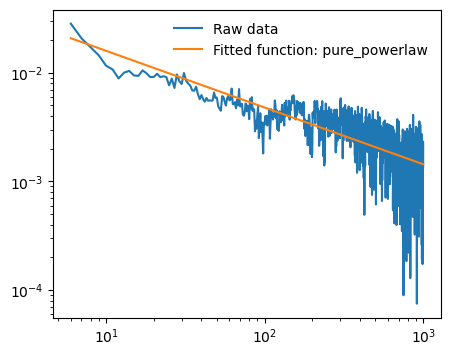

In [31]:
fit.OLS.plot_fit(figure_kwargs={'figsize': (5, 4)})

## 3.3. Identified Scaling Range xmin

In [32]:
### Estimate xmin
print(f'TSLA pure_powerlaw law xmin: {fit.pure_powerlaw.xmin}')


TSLA pure_powerlaw law xmin: 6.0


## 3.4. Estimated alpha

In [33]:
### Estimate alpha
print(f'Alpha found by {fit.OLS.fitted_function} using {fit.OLS.fitting_method} is: {fit.OLS.params.alpha}')

Alpha found by pure_powerlaw using OLS is: -0.5214958543017825


## 3.3. Linear fit of pure power law function on loglog

### Observe fitted function

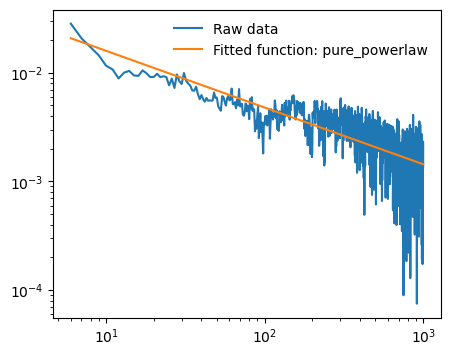

In [18]:
fit.OLS.plot_fit(figure_kwargs={'figsize': (5, 4)})

### Identify Scaling Range xmin

In [39]:
### Estimate xmin
print(f'TSLA pure power law xmin: {fit.OLS.xmin}')

TSLA pure power law xmin: 6.0


### Estimate scaling parameter alpha

In [34]:
### Estimate alpha
print(f'Alpha found by {fit.OLS.fitted_function} using {fit.OLS.fitting_method} is: {fit.OLS.params.alpha}')

Alpha found by pure_powerlaw using OLS is: -0.5214958543017825


# 4. Quantifying the degree of long memory through the Hurst Exponent

In [21]:
# Create an instance of HurstEstimator for Returns
hurst_returns_acf = HurstEstimator(fit.y_values)

In [22]:
# alpha
alpha = fit.powerlaw_with_lin_svf.params.alpha

# Estimate Hurst exponent via standard deviation scaling
H, D, data, interpretation = hurst_returns_acf.estimate('generalized_hurst')
print(f"Hurst Estimate via Generalised Hurst: {H}, D constant: {D if D is not None else 'N/A'} ({interpretation})")

# Estimate Hurst exponent using R/S method
H, c, data, interpretation = hurst_returns_acf.estimate('rescaled_range', kind='random_walk')
print(f"Hurst Estimate via R/S: {H}, c constant: {c if c is not None else 'N/A'} ({interpretation})")

# Compute Hurst from alpha
H, _, _, interpretation = hurst_returns_acf.estimate('hurst_from_alpha', alpha=alpha)
print(f"hurst_from_alpha: {H},  Alpha: {alpha}, ({interpretation})")

Hurst Estimate via Generalised Hurst: 0.6760323866628406, D constant: 0.010821306171650833 (Super-diffusive: series demonstrates persistent long-range dependence)
Hurst Estimate via R/S: 0.7427811520903091, c constant: 0.30601741970468904 (Super-diffusive: series demonstrates persistent long-range dependence)
hurst_from_alpha: 0.3190508985497834,  Alpha: 1.3618982029004332, (Sub-diffusive: series demonstrates anti-persistent behavior)


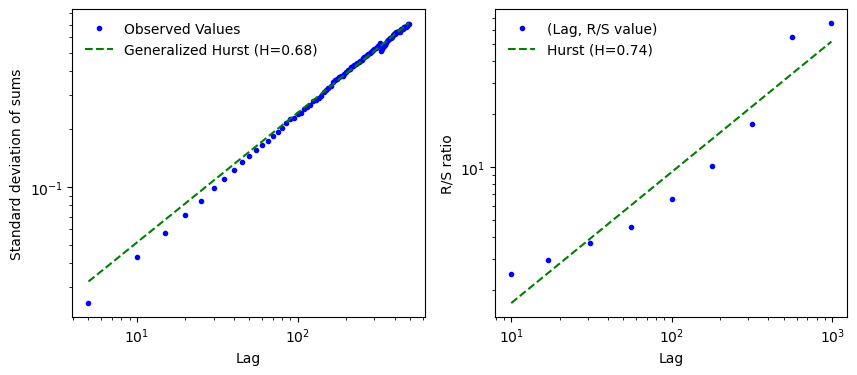

In [23]:
# Plot Generalised Hurst vs. Hurst from R/S
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Generalized Hurst
H, D, data, interpretation = hurst_returns_acf.estimate('generalized_hurst', fitting_method='direct_fit')
chunk_sizes, y_values = data
axs[0].plot(chunk_sizes, y_values, 'b.',  label='Observed Values')
axs[0].plot(chunk_sizes, D*np.array(chunk_sizes)**H, "g--", label=f'Generalized Hurst (H={H:.2f})')
axs[0].loglog()
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Standard deviation of sums')
axs[0].legend(frameon=False)
axs[0].grid(False)

# Rescaled Range
H, c, data, interpretation = hurst_returns_acf.estimate('rescaled_range', kind='random_walk')
axs[1].plot(data[0], data[1],  'b.', label='(Lag, R/S value)')
axs[1].plot(data[0], c*data[0]**H, 'g--', label=f'Hurst (H={H:.2f})')
axs[1].loglog()
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('R/S ratio')
axs[1].legend(frameon=False)
axs[1].grid(False)

# Display the figure with the plots
plt.show()


# 5. Goodness of Fit

## 5.1. Individual goodness of fit tests

As we're fitting power law models to autocorrelation function (ACF) data using nonlinear least squares, our problem setup is deterministic, not a probabilistic: Because we're not directly modeling the probability distribution of the data or residuals, traditional statistical approaches like maximum likelihood estimation (MLE) for fitting and Kolmogorov-Smirnov (KS) statistic for assessing the goodness of fit, are not directly applicable as they are generally used for fitting and model comparison in probabilistic contexts. In such a setting, we would be fitting models to data given the need to model the probability distribution of a single variable, not functions to functions (i.e., when we  want to model a response variable as a function of a predictor variable, as in the current context).</b>

As we're interested in finding the best functional form via least squares approximation, which is closer to the realm of approximation theory and deterministic modeling, goodness-of-fit measures like Adjusted R-square, which reflect the quality of the approximation rather than probabilistic prediction, are more suitable for our setting. Here, a higher R-squared may indicate that the model assumptions are more likely to be satisfied when used to assess the goodness-of-fit of a single model to the data.</b>

However, due to potential nonolinear dependencies that may present in the data (While R-squared is often used for linear models, its utility can diminish when dealing with non-linear models or specific types of data and distributions), we caution against lone use of Adjusted R-squared. Therefore, to determine whether the power law can be considered a good/adequate model, we use Adjusted R-squared along with the Bayesian Information Criterion (BIC) computed from the fitted residuals, which are subsequently used for model selection (see below).</b>

Similar to Adjusted R-squared, BIC help to balance the trade-off between goodness-of-fit and model complexity. It takes into account the likelihood of the model (how well the model fits the data) but also penalize more complex models to avoid overfitting. The lower the value BIC the better the fit.


### pure_powerlaw

In [35]:
print(f'Goodness of fit for {fit.pure_powerlaw.fitted_function}')
print('Alpha:', fit.pure_powerlaw.params.alpha)
print('R-squared:', fit.pure_powerlaw.adjusted_rsquared)
print('BIC:', fit.pure_powerlaw.bic)

Goodness of fit for pure_powerlaw
Alpha: -0.4586471320980997
R-squared: 0.7500080259620638
BIC: -10827.137880593798


### powerlaw_with_exp_svf

In [39]:
fit.function_compare('pure_powerlaw', 'lognormal_function')
# print(f'Goodness of fit for {fit.powerlaw_with_exp_svf.fitted_function}')
# print('Alpha:', fit.powerlaw_with_exp_svf.params.alpha)
# print('R-squared:', fit.powerlaw_with_exp_svf.adjusted_rsquared)
# print('BIC:', fit.powerlaw_with_exp_svf.bic)

(6.512346113446509, 7.398599644885571e-11)

### powerlaw_with_log_svf

In [26]:
print(f'Goodness of fit for {fit.powerlaw_with_log_svf.fitted_function}')
print('Alpha:', fit.powerlaw_with_log_svf.params.alpha)
print('R-squared:', fit.powerlaw_with_log_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_log_svf.bic)

Goodness of fit for powerlaw_with_log_svf
Alpha: 0.43151600415236985
R-squared: 0.7518532921194071
BIC: -13164.050837689076


### powerlaw_with_lin_svf

In [27]:
print(f'Goodness of fit for {fit.powerlaw_with_lin_svf.fitted_function}')
print('Alpha:', fit.powerlaw_with_lin_svf.params.alpha)
print('R-squared:', fit.powerlaw_with_lin_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_lin_svf.bic)

Goodness of fit for powerlaw_with_lin_svf
Alpha: 1.3618982029004332
R-squared: 0.7789964977103676
BIC: -13114.667020114337


### powerlaw_with_per_svf

In [28]:
print(f'Goodness of fit for {fit.powerlaw_with_per_svf.fitted_function}')
print('Alpha:', fit.powerlaw_with_per_svf.params.alpha)
print('R-squared:', fit.powerlaw_with_per_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_per_svf.bic)

Goodness of fit for powerlaw_with_per_svf
Alpha: 0.4539408773350433
R-squared: 0.7569875196984526
BIC: -13151.297815244547


### linear_fit_ols

In [29]:
print(f'Goodness of fit for {fit.linear_fit_ols.fitting_method}')
print('Alpha:', fit.linear_fit_ols.params.alpha)
print('R-squared:', fit.linear_fit_ols.adjusted_rsquared)
print('BIC:', fit.linear_fit_ols.bic)

Goodness of fit for linear_fit_ols
Alpha: -0.5214958543017825
R-squared: 0.7293114135653844
BIC: -12935.635734810352


## 5.2. Direct comparison of fitted functions

Note that while BIC can be useful for comparing different models, it doesn't provide a measure of the absolute quality of a model. For instance, a model with a lower AIC or BIC is considered better than a model with a higher value, but this doesn't tell us if either model is actually good or suitable for our data (i.e., the magnitude of BIC itself gives no indication of a direct measure of goodness-of-fit. Following Clauset, Shalizi and Newman (2009), we construct a like-lihood ratio test proposed by Vuong (1989) (LRT) for determinisitc functions. This approach has several attractive features, including the ability to sufficiently distinguish whether some other model might be an equally plausible or even a better explanation as well as the ability to fail to distinguish between the power law and an alternative, for example, in the event of a tie.</b>

### Likelihood Ratio Tests

Whilst Clauset, Shalizi and Newman (2009) primarily focuses on fitting power-law distributions to data and assessing the goodness of fit for those distributions, their methods are not applicable to determinisitc functions (such as ACF with slowly varying functions). In their case traditional statistical approaches like MLE and using the KS-distance used for fitting and statistical goodness-of-fit, respectively, are used for model comparison in probabilistic contexts where authors are fitting known functiona to probablity distirubtions, not functions to functions. In this regard, the authors do not make explicit assumptions about the distribution of residuals because they are dealing directly with probabilistic models (i.e., they assume that the data follows a power-law distribution and fit their models based on that). </b>

To  bridge the gap between deterministic modeling (i.e., in our context, we are interested in fitting a power-law model to ACF data using nonlinear least squares) and probabilistic modeling (i.e., fitting a power-law distribution to data), we assume a distribution for the residuals by evaluating the distribution against competing distributions using loglikiehood and Kolmogorov-Smirnov test). By assuming a distribution for the residuals, we effectively transform our deterministic model into a probabilistic model: We are stating that our observed data is equal to the model's prediction plus some random noise (the residuals), and this random noise follows a certain probability distribution, which allows for statistical hypothesis testing. This makes it possible to compute a significance level to determine whether one model is statistically better than the other, or whether the evidence is not strong enough to favor one model over the other.</b>

Thus, assuming the residuals follow a specific distribution (like a Gaussian), we calculate the log-likelihood of the residuals for each model which enables us to compute the R, loglikelihood ratio between the two candidate distributions, and p, significance value for that direction.

##### R Interpretation

To assess the absolute quality of a model, here we take inspiration from Clauset, Shalizi and Newman (2009) and use Vuong's method to compare the goodness-of-fit between two models, which relies on likelihood ratio tests. Likelihood ratio tests are a powerful statistical tool for model comparison, but they're usually only applicable when one model is a nested version of the other (i.e., the simpler model can be obtained from the more complex model by setting some parameters to specific values). Vuong extends this concept to non-nested models by considering the Kullback-Leibler information criterion, which is a measure of the amount of information lost when a specific model is used to approximate reality. Vuong's method uses this criterion to establish a likelihood ratio test for non-nested models.</b>

R is the loglikelihood ratio between the two candidate distributions. This is a measure of the difference in the fit of the two models. A positive value indicates that the first model (in this case, the one associated with log_likelihood1 or the fitting_func1) is a better fit than the second model (the one associated with log_likelihood2 or the fitting_func2), while a negative value would suggest the opposite. The magnitude of R provides an indication of the extent of the difference.

##### p-value Interpretation:

The p-value used in hypothesis testing helps us decide whether to reject the null hypothesis. The null hypothesis for this test is that the two models are equally good at explaining the data. A small p-value (typically less than 0.05 or 0.1 depending on the chosen significance level) is strong evidence to reject the null hypothesis:

Therefore, if the R value is positive (indicating that the data is more likely under the power-law model), and the p-value is small (indicating that this result is unlikely due to chance), then we would have evidence in favor of the power-law distribution, and we can conclude that the sign of R is statistically significant, indicating a better fit for one model over the other. Conversely, if the R value is negative (indicating that the data is more likely under the alternative distribution), and the p-value is small, then you would have evidence in favor of the alternative distribution. A p-value of 0.0 would indeed suggest that the likelihood that the two models (the power-law function and the alternative function) are equally good is virtually zero. Consequently, this would allow us to firmly reject the null hypothesis given likelihood that the two models are equally good is virtually zero. To summarise:

-  If R > 0 and the p-value is 0, this suggests that the power-law model is a significantly better fit for the data than the alternative model.
-  If R < 0 and the p-value is 0, this suggests that the alternative model is a significantly better fit for the data than the power-law model.

### powerlaw_with_lin_svf vs. Exponential fit

In [30]:
# Using best fitted function according to R-squared and BIC - powerlaw_with_lin_svf
print('powerlaw_with_lin_svf')
print('Alpha:', fit.powerlaw_with_lin_svf.params.alpha)
print('R_sqaured:', fit.powerlaw_with_lin_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_lin_svf.bic)

print()
print('Exponential ')
R, p = fit.function_compare('powerlaw_with_lin_svf', 'exponential_function')
print('Lambda:', fit.exponential_function.params.lambda_)
print('R_sqaured:', fit.exponential_function.adjusted_rsquared)
print('BIC:', fit.exponential_function.bic)
print()

print(f'Likelihood Ratio: {R}, p.value: {p}')

powerlaw_with_lin_svf
Alpha: 1.3618982029004332
R_sqaured: 0.7789964977103676
BIC: -13114.667020114337

Exponential 
Lambda: 0.0020129182113730435
R_sqaured: 0.5295177313362095
BIC: -12963.739789549838

Likelihood Ratio: 1.7623637575430269, p.value: 0.07800785793343254


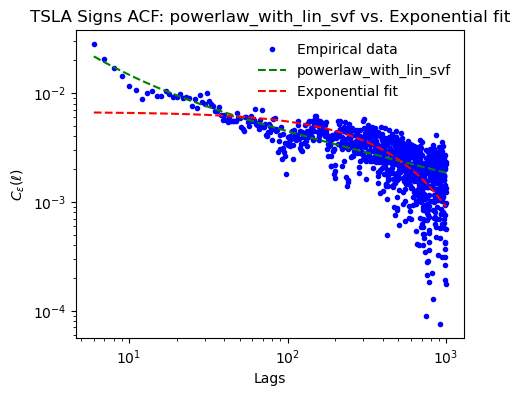

In [31]:
x_values = fit.powerlaw_with_lin_svf.data.xmin_x_values
y_values = fit.powerlaw_with_lin_svf.data.xmin_y_values
powerlaw_fit = fit.powerlaw_with_lin_svf.fitted_values
exponential_fit = fit.exponential_function.fitted_values

# Create plot
plt.figure(figsize=(5, 4))

plt.plot(x_values, y_values, 'b.', label='Empirical data')
plt.plot(x_values, powerlaw_fit, 'g--', label='powerlaw_with_lin_svf')
plt.plot(x_values, exponential_fit, 'r--', label='Exponential fit')
plt.loglog()

plt.title('TSLA Signs ACF: powerlaw_with_lin_svf vs. Exponential fit')
plt.xlabel('Lags')
plt.ylabel(r"$C_\epsilon(\ell)$")
plt.legend(frameon=False)
plt.grid(False)

plt.show()

#### powerlaw_with_lin_svf vs. Logarithmic fit

In [32]:
print()
print('powerlaw_with_lin_svf:')
print('Alpha:', fit.powerlaw_with_lin_svf.params.alpha)
print('R_sqaured:', fit.powerlaw_with_lin_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_lin_svf.bic)

print()
print('Logarithmic:')
R, p = fit.function_compare('powerlaw_with_lin_svf','logarithmic_function')
print('Beta:', fit.logarithmic_function.params.beta)
print('Lambda:', fit.logarithmic_function.params.lambda_)
print('R_sqaured:', fit.logarithmic_function.adjusted_rsquared)
print('BIC:', fit.logarithmic_function.bic)
print()

print(f'Likelihood Ratio: {R}, p.value: {p}')


powerlaw_with_lin_svf:
Alpha: 1.3618982029004332
R_sqaured: 0.7789964977103676
BIC: -13114.667020114337

Logarithmic:
Beta: 0.013798068359407528
Lambda: -0.0018303953964862343
R_sqaured: 0.6725576222282743
BIC: -13039.66475390843

Likelihood Ratio: 1.0961631242039824, p.value: 0.27300739408639296


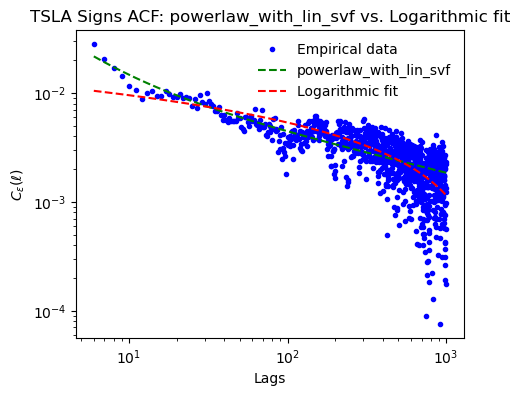

In [33]:
x_values = fit.powerlaw_with_lin_svf.data.xmin_x_values
y_values = fit.powerlaw_with_lin_svf.data.xmin_y_values
powerlaw_fit = fit.powerlaw_with_lin_svf.fitted_values
logarithmic_fit = fit.logarithmic_function.fitted_values

# Create plot
plt.figure(figsize=(5, 4))

plt.plot(x_values, y_values, 'b.', label='Empirical data')
plt.plot(x_values, powerlaw_fit, 'g--', label='powerlaw_with_lin_svf')
plt.plot(x_values, logarithmic_fit, 'r--', label='Logarithmic fit')
plt.loglog()

plt.title('TSLA Signs ACF: powerlaw_with_lin_svf vs. Logarithmic fit')
plt.xlabel('Lags')
plt.ylabel(r"$C_\epsilon(\ell)$")
plt.legend(frameon=False)
plt.grid(False)

plt.show()

### powerlaw_with_lin_svf vs. Linear fit

In [34]:
print()
print('powerlaw_with_lin_svf:')
print('Alpha:', fit.powerlaw_with_lin_svf.params.alpha)
print('R_sqaured:', fit.powerlaw_with_lin_svf.adjusted_rsquared)
print('BIC:', fit.powerlaw_with_lin_svf.bic)

print()
print('Logarithmic:')
R, p = fit.function_compare('powerlaw_with_lin_svf','linear_function', nested=True)
print('Beta:', fit.linear_function.params.beta)
print('Lambda:', fit.linear_function.params.lambda_)
print('R_sqaured:', fit.linear_function.adjusted_rsquared)
print('BIC:', fit.linear_function.bic)
print()

print(f'Likelihood Ratio: {R}, p.value: {p}')


powerlaw_with_lin_svf:
Alpha: 1.3618982029004332
R_sqaured: 0.7789964977103676
BIC: -13114.667020114337

Logarithmic:
Beta: 0.005336172985322666
Lambda: -4.785991418131067e-06
R_sqaured: 0.44169236369889253
BIC: -12858.33074219147

Likelihood Ratio: 2.8753941329774686, p.value: 0.016481259792485936


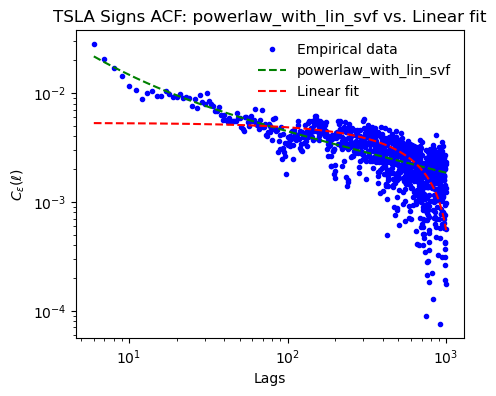

In [35]:
x_values = fit.powerlaw_with_lin_svf.data.xmin_x_values
y_values = fit.powerlaw_with_lin_svf.data.xmin_y_values
powerlaw_fit = fit.powerlaw_with_lin_svf.fitted_values
linear_fit = fit.linear_function.fitted_values

# Create plot
plt.figure(figsize=(5, 4))

plt.plot(x_values, y_values, 'b.', label='Empirical data')
plt.plot(x_values, powerlaw_fit, 'g--', label='powerlaw_with_lin_svf')
plt.plot(x_values, linear_fit, 'r--', label='Linear fit')
plt.loglog()

plt.title('TSLA Signs ACF: powerlaw_with_lin_svf vs. Linear fit')
plt.xlabel('Lags')
plt.ylabel(r"$C_\epsilon(\ell)$")
plt.legend(frameon=False)
plt.grid(False)

plt.show()

## 5.3. Comparing power law fits accross all assets

### 5.3.1. Retrieve all fitted parameters

In [36]:
# Fit power laws for all stocks and store results
fit_results_all_stocks = []
stock_fits = {}
for stock_name, stock_df in stock_xy_values.items():
    stock_fit = Fit(stock_df, verbose=False)
    stock_fits[stock_name] = stock_fit
    results_df = stock_fit.return_all_fitting_results()
    results_df['stock'] = stock_name
    fit_results_all_stocks.append(results_df)

In [37]:
all_results_df = pd.concat(fit_results_all_stocks)

In [38]:
all_results_df.sort_values(['stock', 'bic', 'adjusted r-squared'], ascending=[True, True, False]).reset_index()

,index,name,fitted function,xmin_index,xmin,fitting param,adjusted r-squared,bic,stock
0,3,powerlaw_with_lin_svf,<function powerlaw_with_lin_svf at 0x7fd2e99e2...,6,7.0,"{'alpha': 1.3080407340256013, 'beta': 0.212531...",0.9123,-13679.7008,AMZN
1,6,linear_fit_robust_regression,<function pure_powerlaw at 0x7fd2e99e21f0>,6,7.0,"{'alpha': -0.3815284505140397, 'C': 0.04273282...",0.8556,-13612.0555,AMZN
2,5,linear_fit_ols,<function pure_powerlaw at 0x7fd2e99e21f0>,6,7.0,"{'alpha': -0.39191253513889973, 'C': 0.0449598...",0.8617,-13587.9130,AMZN
3,7,linear_fit_generalised_regression,<function pure_powerlaw at 0x7fd2e99e21f0>,6,7.0,"{'alpha': -0.39191253513889973, 'C': 0.0449598...",0.8617,-13587.9130,AMZN
4,4,powerlaw_with_per_svf,<function powerlaw_with_per_svf at 0x7fd2e99e2...,6,7.0,"{'alpha': 0.42549419597566407, 'a0': 0.0545173...",0.8762,-13481.9523,AMZN
5,1,powerlaw_with_exp_svf,<function powerlaw_with_exp_svf at 0x7fd2e99e2...,6,7.0,"{'alpha': 0.49510427168026927, 'beta': 0.06837...",0.8874,-13471.6679,AMZN
6,0,pure_powerlaw,<function pure_powerlaw at 0x7fd2e99e21f0>,6,7.0,"{'alpha': -0.4265185144728093, 'C': 0.05483893...",0.8748,-13465.0079,AMZN
7,2,powerlaw_with_log_svf,<function powerlaw_with_log_svf at 0x7fd2e99e2...,6,7.0,"{'alpha': 0.4265409713823879, 'beta': 0.054838...",0.8747,-13458.0966,AMZN
8,3,powerlaw_with_lin_svf,<function powerlaw_with_lin_svf at 0x7fd2e99e2...,8,9.0,"{'alpha': 1.1937207443416726, 'beta': 0.156223...",0.7436,-13722.6598,APPL
9,6,linear_fit_robust_regression,<function pure_powerlaw at 0x7fd2e99e21f0>,9,10.0,"{'alpha': -0.38348855411951804, 'C': 0.0174838...",0.6093,-13650.1584,APPL


In [39]:
# For each stock what is the power law fit with the highest adjusted R squared
all_results_df.groupby('stock').apply(lambda x: x.loc[(x['adjusted r-squared'] == x['adjusted r-squared'].max()), 'name']).reset_index(level=1, drop=True)

stock
AMZN    powerlaw_with_lin_svf
APPL    powerlaw_with_lin_svf
EBAY    powerlaw_with_lin_svf
MSFT    powerlaw_with_per_svf
NFLX    powerlaw_with_lin_svf
TSLA    powerlaw_with_lin_svf
Name: name, dtype: object

In [40]:
# For each stock what is the power law fit with the lowest BIC
all_results_df.groupby('stock').apply(lambda x: x.loc[(x['bic'] == x['bic'].min()), 'name']).reset_index(level=1, drop=True)

stock
AMZN                powerlaw_with_lin_svf
APPL                powerlaw_with_lin_svf
EBAY                       linear_fit_ols
EBAY    linear_fit_generalised_regression
MSFT                       linear_fit_ols
MSFT    linear_fit_generalised_regression
NFLX                        pure_powerlaw
TSLA                powerlaw_with_log_svf
Name: name, dtype: object

In [41]:
all_results_df[all_results_df['name'] == 'powerlaw_with_lin_svf'][['stock', 'xmin', 'fitting param', 'bic']]

,stock,xmin,fitting param,bic
3,TSLA,6.0,"{'alpha': 1.3618982029004332, 'beta': 0.115351...",-13114.6670
3,MSFT,6.0,"{'alpha': 0.9418211479253137, 'beta': 0.000657...",-7168.6790
3,AMZN,7.0,"{'alpha': 1.3080407340256013, 'beta': 0.212531...",-13679.7008
3,NFLX,2.0,"{'alpha': 1.360330394180184, 'beta': 0.1284170...",-12507.7599
3,EBAY,4.0,"{'alpha': 0.9971941645876873, 'beta': 0.005549...",-6401.0222
3,APPL,9.0,"{'alpha': 1.1937207443416726, 'beta': 0.156223...",-13722.6598


### 5.3.2  Comparing power law to alternative functions

### Direct comparison of powerlaw_with_lin_svf vs Others

#### Retrieve fitted parameters for Direct comparison

In [42]:
def get_comparison_results_for_stock(fit):
    compare_result = {}
    compare_result['powerlaw alpha'] = fit.powerlaw_with_lin_svf.params.alpha
    compare_result['powerlaw r squared'] = fit.powerlaw_with_lin_svf.adjusted_rsquared
    compare_result['powerlaw bic'] = fit.powerlaw_with_lin_svf.bic

    hurst_abs_returns_acf = HurstEstimator(fit.y_values)
    H, D, data, interpretation = hurst_abs_returns_acf.estimate('generalized_hurst')
    compare_result['Hurst exponent'] = H

    R, p = fit.function_compare('powerlaw_with_lin_svf', 'exponential_function', nested=True)

    compare_result['exponential lambda'] = fit.exponential_function.params.lambda_
    compare_result['exponential r squared'] = fit.exponential_function.adjusted_rsquared
    compare_result['exponential bic'] = fit.exponential_function.bic

    compare_result['powerlaw vs exp R'] = R
    compare_result['powerlaw vs exp p'] = p

    R, p = fit.function_compare('powerlaw_with_lin_svf', 'logarithmic_function')

    compare_result['logarithmic lambda'] = fit.logarithmic_function.params.lambda_
    compare_result['logarithmic beta'] = fit.logarithmic_function.params.beta
    compare_result['logarithmic r squared'] = fit.logarithmic_function.adjusted_rsquared
    compare_result['logarithmic bic'] = fit.logarithmic_function.bic

    compare_result['powerlaw vs log R'] = R
    compare_result['powerlaw vs log p'] = p

    R, p = fit.function_compare('powerlaw_with_lin_svf', 'linear_function', nested=True)

    compare_result['linear lambda'] = fit.linear_function.params.lambda_
    compare_result['linear beta'] = fit.linear_function.params.beta
    compare_result['linear r squared'] = fit.linear_function.adjusted_rsquared
    compare_result['linear bic'] = fit.linear_function.bic

    compare_result['powerlaw vs lin R'] = R
    compare_result['powerlaw vs lin p'] = p

    return pd.Series(compare_result)

In [43]:
compare_exp_results = []
for stock_name, stock_fit in stock_fits.items():
    comp_res = get_comparison_results_for_stock(stock_fit)
    comp_res['stock name'] = stock_name
    compare_exp_results.append(comp_res)

In [44]:
compare_results_df = pd.concat(compare_exp_results, axis=1)
compare_results_df.columns = compare_results_df.loc['stock name']

In [45]:
compare_results_df

stock name,TSLA,MSFT,AMZN,NFLX,EBAY,APPL
powerlaw alpha,1.361898,0.941821,1.308041,1.36033,0.997194,1.193721
powerlaw r squared,0.778996,-0.002936,0.912305,0.934983,0.007836,0.74355
powerlaw bic,-13114.66702,-7168.678997,-13679.700807,-12507.759896,-6401.022227,-13722.659792
Hurst exponent,0.676032,0.034729,0.587051,0.42211,0.530704,0.520359
exponential lambda,0.002013,0.956915,0.001627,0.37635,3.938154,0.001562
exponential r squared,0.529518,-1.925495,0.522778,0.759036,-1.723848,0.340109
exponential bic,-12963.73979,-6698.123618,-12677.338642,-10985.050709,-6026.087204,-13417.180187
powerlaw vs exp R,1.762364,6.684594,10.29456,19.388964,5.634956,3.664951
powerlaw vs exp p,0.06046,0.000256,0.000006,0.0,0.000788,0.006782
logarithmic lambda,-0.00183,0.000027,-0.002562,-0.001163,-0.000061,-0.001087


#### Plot fits

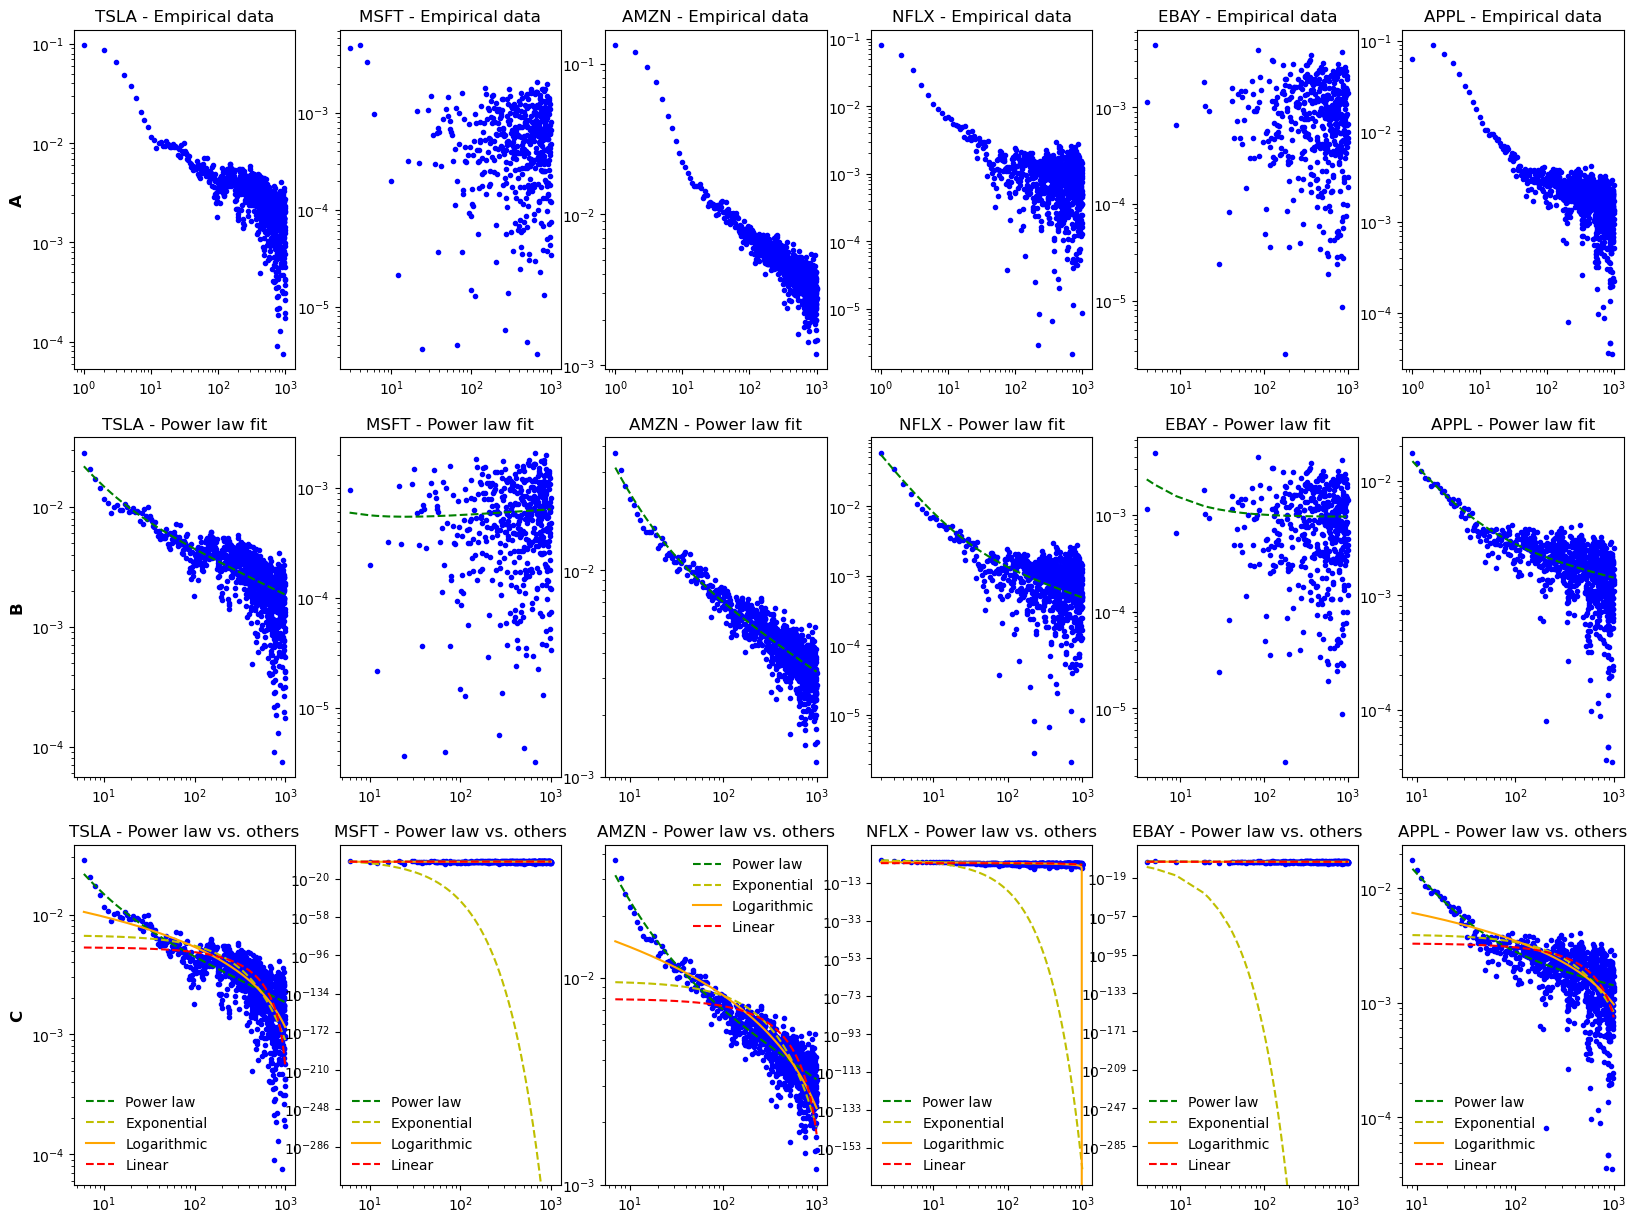

In [46]:
fig, axs = plt.subplots(3, len(stock_fits), figsize=(20, 15))
for i, (stock_name, fit) in enumerate(stock_fits.items()):
    axs[0, i].loglog(fit.x_values, fit.y_values, 'b.')
    axs[0, i].set_title(f'{stock_name} - Empirical data')
    axs[0, i].grid(False)
    if i == 0:
        axs[0, i].set_ylabel('A', size='large', weight='bold')

    x_values = fit.powerlaw_with_lin_svf.data.xmin_x_values
    y_values = fit.powerlaw_with_lin_svf.data.xmin_y_values
    powerlaw_fit = fit.powerlaw_with_lin_svf.fitted_values
    axs[1, i].loglog(x_values, y_values, 'b.')
    axs[1, i].loglog(x_values, powerlaw_fit, 'g--')
    axs[1, i].set_title(f'{stock_name} - Power law fit')
    axs[1, i].grid(False)
    if i == 0:
        axs[1, i].set_ylabel('B', size='large', weight='bold')


    exp_fit = fit.exponential_function.fitted_values
    log_fit = fit.logarithmic_function.fitted_values
    lin_fit = fit.linear_function.fitted_values
    axs[2, i].loglog(x_values, y_values, 'b.')
    axs[2, i].loglog(x_values, powerlaw_fit, 'g--', label='Power law')
    axs[2, i].loglog(x_values, exp_fit, 'y--', label='Exponential')
    axs[2, i].loglog(x_values, log_fit, 'orange', label='Logarithmic')
    axs[2, i].loglog(x_values, lin_fit, 'r--', label='Linear')
    axs[2, i].set_title(f'{stock_name} - Power law vs. others')
    axs[2, i].grid(False)
    axs[2, i].legend(frameon=False)
    if i == 0:
        axs[2, i].set_ylabel('C', size='large', weight='bold')